# Import Libraries

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# modelling for ensemble method
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import seaborn as sns
import matplotlib.pyplot as plt

# Data Loading

In [2]:
df = pd.read_csv('../dataset/data.csv')

In [3]:
# dataset splitting 
X, y = df.drop(['IDNumber','diagnosis'], axis=1), df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
# reset index dari data training dan data testing agar tidak error saat indexing
# X_train.reset_index(drop=True, inplace=True)
# X_test.reset_index(drop=True, inplace=True)

# y_train.reset_index(drop=True, inplace=True)
# y_test.reset_index(drop=True, inplace=True)

# Defining Global Variables 

In [5]:
kfold = StratifiedKFold(n_splits=5, random_state=45, shuffle=True)

# Data Preprocessing

## Data Normalization
***
Using Min-Max Scaler

In [6]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Label Encoding Target
***
Convert B --> 0 and M --> 1

In [7]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [8]:
# X_train = X_train.to_numpy()
# X_test = X_test.to_numpy()
# y_train = y_train.to_numpy()
# y_test = y_test.to_numpy()

# Modelling

## Create Stacking ML Ensemble from 5-fold cross-validation

In [9]:
ensemble_classifiers = {
    'svm' : dict(),
    'logreg': dict(),
    'naive_bayes': dict(),
    'decision_tree': dict()
}

for idx, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):
    
    # split training set into train and val set
    X_latih, X_validasi = X_train[train_index], X_train[val_index]
    y_latih, y_validasi = y_train[train_index], y_train[val_index]
    
    # train 5 model of SVM
    svm = SVC()
    svm.fit(X_latih, y_latih)
    predicted_svm = svm.predict(X_validasi)
    
    ensemble_classifiers['svm']['model-'+str(idx+1)] = {
        'train':svm,
        'validation': accuracy_score(y_validasi, predicted_svm)
    }
    
    # train 5 model of logReg
    log_reg = LogisticRegression()
    log_reg.fit(X_latih, y_latih)
    predicted_log_reg = log_reg.predict(X_validasi)
    
    ensemble_classifiers['logreg']['model-'+str(idx+1)] = {
        'train':log_reg,
        'validation': accuracy_score(y_validasi, predicted_log_reg)
    }
    
    # train 5 model of Naive Bayes
    naive_bayes = MultinomialNB()
    naive_bayes.fit(X_latih, y_latih)
    predicted_naive_bayes = naive_bayes.predict(X_validasi)
    
    ensemble_classifiers['naive_bayes']['model-'+str(idx+1)] = {
        'train':naive_bayes,
        'validation': accuracy_score(y_validasi, predicted_naive_bayes)
    }
    
    # train 5 model of Decision Tree
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X_latih, y_latih)
    predicted_decision_tree = decision_tree.predict(X_validasi)
    
    ensemble_classifiers['decision_tree']['model-'+str(idx+1)] = {
        'train':decision_tree,
        'validation': accuracy_score(y_validasi, predicted_decision_tree)
    }

In [10]:
ensemble_classifiers

{'svm': {'model-1': {'train': SVC(), 'validation': 0.975},
  'model-2': {'train': SVC(), 'validation': 0.975},
  'model-3': {'train': SVC(), 'validation': 0.95},
  'model-4': {'train': SVC(), 'validation': 0.9620253164556962},
  'model-5': {'train': SVC(), 'validation': 0.9873417721518988}},
 'logreg': {'model-1': {'train': LogisticRegression(), 'validation': 0.95},
  'model-2': {'train': LogisticRegression(), 'validation': 0.95},
  'model-3': {'train': LogisticRegression(), 'validation': 0.9375},
  'model-4': {'train': LogisticRegression(), 'validation': 0.9620253164556962},
  'model-5': {'train': LogisticRegression(), 'validation': 1.0}},
 'naive_bayes': {'model-1': {'train': MultinomialNB(), 'validation': 0.875},
  'model-2': {'train': MultinomialNB(), 'validation': 0.8125},
  'model-3': {'train': MultinomialNB(), 'validation': 0.875},
  'model-4': {'train': MultinomialNB(), 'validation': 0.8354430379746836},
  'model-5': {'train': MultinomialNB(), 'validation': 0.7721518987341772}}

## Training the stacking ensemble ML

In [11]:
all_predicted_results = dict()
list_of_majority_voting_each_models = list()

for model_name, models in ensemble_classifiers.items():
    print("\t\t\t", model_name.upper())
    
    # voting scenario for data training input prepration for ANN model
    if len(models)!=0:
        all_predicted_results[model_name] = dict()
        for sub_model_name, dict_models in models.items():
            print('\t\t Training Model {} using {}'.format(model_name.upper(), sub_model_name))
            all_predicted_results[model_name][sub_model_name] = dict_models['train'].predict(X_train)
        
        # make dataframe for 5 model prediction results on X_train and get the mode label for that 5 prediction
        model_df_voting = pd.DataFrame(all_predicted_results[model_name]).mode(axis=1)
        model_df_voting.columns = ['majority_vote_from_'+model_name]
        list_of_majority_voting_each_models.append(model_df_voting)

			 SVM
		 Training Model SVM using model-1
		 Training Model SVM using model-2
		 Training Model SVM using model-3
		 Training Model SVM using model-4
		 Training Model SVM using model-5
			 LOGREG
		 Training Model LOGREG using model-1
		 Training Model LOGREG using model-2
		 Training Model LOGREG using model-3
		 Training Model LOGREG using model-4
		 Training Model LOGREG using model-5
			 NAIVE_BAYES
		 Training Model NAIVE_BAYES using model-1
		 Training Model NAIVE_BAYES using model-2
		 Training Model NAIVE_BAYES using model-3
		 Training Model NAIVE_BAYES using model-4
		 Training Model NAIVE_BAYES using model-5
			 DECISION_TREE
		 Training Model DECISION_TREE using model-1
		 Training Model DECISION_TREE using model-2
		 Training Model DECISION_TREE using model-3
		 Training Model DECISION_TREE using model-4
		 Training Model DECISION_TREE using model-5


In [12]:
new_input_training_features = pd.concat(list_of_majority_voting_each_models, axis=1)
new_input_training_features['ground_truth'] = y_train.copy()

In [13]:
new_input_training_features

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
393,0,0,0,0,0
394,0,0,0,0,0
395,0,0,0,0,0
396,1,1,0,1,1


## Feed New Input features into ANN

In [14]:
# split X and y from new_input_features before feeding to ANN
new_X_train, new_y_train = new_input_training_features.drop(['ground_truth'],axis=1), new_input_training_features['ground_truth']
# new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.2, random_state=45)

# feed new X and new y into ANN
ann_model = MLPClassifier(max_iter=400)
ann_model.fit(new_X_train, new_y_train)

predicted_ann_train = ann_model.predict(new_X_train)

In [15]:
accuracy_score(new_y_train, predicted_ann_train)

1.0

# Testing Model

In [16]:
all_predicted_results = dict()
list_of_majority_voting_each_models = list()

for model_name, models in ensemble_classifiers.items():
    print("\t\t\t", model_name.upper())
    
    # voting scenario for data testing input prepration for ANN model
    if len(models)!=0:
        all_predicted_results[model_name] = dict()
        for sub_model_name, dict_models in models.items():
            print('\t\t Testing Model {} using {}'.format(model_name.upper(), sub_model_name))
            all_predicted_results[model_name][sub_model_name] = dict_models['train'].predict(X_test)
        
        # make dataframe for 5 model prediction results on X_test and get the mode label for that 5 prediction
        model_df_voting = pd.DataFrame(all_predicted_results[model_name]).mode(axis=1)
        model_df_voting.columns = ['majority_vote_from_'+model_name]
        list_of_majority_voting_each_models.append(model_df_voting)

			 SVM
		 Testing Model SVM using model-1
		 Testing Model SVM using model-2
		 Testing Model SVM using model-3
		 Testing Model SVM using model-4
		 Testing Model SVM using model-5
			 LOGREG
		 Testing Model LOGREG using model-1
		 Testing Model LOGREG using model-2
		 Testing Model LOGREG using model-3
		 Testing Model LOGREG using model-4
		 Testing Model LOGREG using model-5
			 NAIVE_BAYES
		 Testing Model NAIVE_BAYES using model-1
		 Testing Model NAIVE_BAYES using model-2
		 Testing Model NAIVE_BAYES using model-3
		 Testing Model NAIVE_BAYES using model-4
		 Testing Model NAIVE_BAYES using model-5
			 DECISION_TREE
		 Testing Model DECISION_TREE using model-1
		 Testing Model DECISION_TREE using model-2
		 Testing Model DECISION_TREE using model-3
		 Testing Model DECISION_TREE using model-4
		 Testing Model DECISION_TREE using model-5


In [17]:
new_input_testing_features = pd.concat(list_of_majority_voting_each_models, axis=1)
new_input_testing_features['ground_truth'] = y_test.copy()

In [18]:
# split X and y from new_input_features before feeding to ANN
new_X_test, new_y_test = new_input_testing_features.drop(['ground_truth'],axis=1), new_input_testing_features['ground_truth']

# predict new X test using pre-trained ANN before
predicted_ann_testing = ann_model.predict(new_X_test)

In [21]:
print(classification_report(y_test, predicted_ann_testing))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       108
           1       0.94      0.95      0.94        63

    accuracy                           0.96       171
   macro avg       0.95      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



<AxesSubplot: >

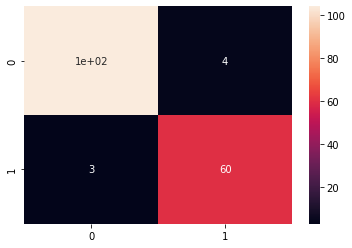

In [30]:
sns.heatmap(confusion_matrix(y_test, predicted_ann_testing), annot=True)